In [1]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import json
from d3rlpy.algos import DiscreteCQL
import torch

plt.style.use('ggplot')

### Inputs

In [2]:
with open('init_state.txt', 'r') as file:
    init_state = file.read()
init_state = json.loads(init_state)
features = list(init_state.keys())

with open('ednet_codes/mdp_dict.txt', 'r') as file:
    mdp_dict = file.read()
mdp_dict = json.loads(mdp_dict)

nrows = None # For debugging
trajectories = pd.read_csv('trajectories_KT3_200k.csv', nrows=nrows)

#Converting states to str
trajectories['state'] = trajectories['state'] .astype('str')
trajectories['next_state'] = trajectories['next_state'] .astype('str')
#Limiting to first 50k users 
user_subset = trajectories['username'].unique()[:50000]
trajectories.query('username in @user_subset', inplace=True)

#################### CHANGE THIS #######################################
mdp_name = "MDP_aug4687"
feat_to_incl = mdp_dict[mdp_name]
########################################################################

transitions = pd.read_csv('trans_ori/original_transitions_{}.csv'.format(mdp_name))
transitions['state'] = transitions['state'] .astype('str')
transitions['next_state'] = transitions['next_state'] .astype('str')

#q_vals = pd.read_csv('policies/Q_{}.csv'.format(mdp_name))
#q_vals.set_index('state', inplace = True)
#q_vals.columns = range(q_vals.shape[1])

target_policy = pd.read_csv('policies_penalised/policy_{}.csv'.format(mdp_name))
# Changing state back to str (from MATLAB)
target_policy['state'] = target_policy['state'].astype('str')
target_policy.rename(columns = {'policy':'action'}, inplace = True)
target_policy.set_index(['state', 'action'], inplace = True)

# Finding feature index
feat_idx = [features.index(feat) for feat in feat_to_incl]

# Extracting relevant features
obs = trajectories['state'].str.split('', expand = True).values[:,1:-1]
n_obs = trajectories['next_state'].str.split('', expand = True).values[:,1:-1]

trajectories['state'] = obs[:,feat_idx].sum(axis =1)
trajectories['next_state'] = n_obs[:,feat_idx].sum(axis =1)

### Deriving Behaviour Policy

In [3]:
sa_count = transitions.groupby(['state','action']).sum()['support']
s_count = transitions.groupby(['state']).sum()['support']
observed_policy = sa_count/s_count
observed_policy.rename('observed_policy', inplace = True)

state    action
1111102  2         0.019231
         3         0.019231
         4         0.019231
         6         0.019231
         7         0.038462
                     ...   
4444824  21        0.014925
         22        0.104478
         23        0.358209
         24        0.402985
         36        0.014925
Name: observed_policy, Length: 175312, dtype: float64

In [4]:
action_size = transitions['action'].unique().shape[0]

transform_type = 'hardcode'

if transform_type == 'hardcode':
    # Hard-code transformation
    eps = 0.1
    target_policy['target_policy'] = 1 - eps
    policies_to_compare = pd.DataFrame(observed_policy)
    policies_to_compare = policies_to_compare.merge(target_policy['target_policy'], how = 'left', left_index = True, right_index = True)
    policies_to_compare.fillna(eps/action_size, inplace = True)
    
elif transform_type == 'softmax':
    prob_soft_max = np.exp(q_vals*0.01).values/np.exp(q_vals*0.01).values.sum(axis = 1).reshape(-1,1)
    prob_soft_max = pd.DataFrame(prob_soft_max, index = target_policy.index.get_level_values(0))
    prob_soft_max = prob_soft_max.melt(value_vars= prob_soft_max.columns,var_name='action', value_name = 'target_policy', ignore_index=False)
    prob_soft_max.set_index('action', append = True, inplace = True)
    policies_to_compare = pd.DataFrame(observed_policy)
    policies_to_compare = policies_to_compare.merge(prob_soft_max, how = 'left', left_index = True, right_index = True)
    
elif transform_type == 'debug':
    policies_to_compare = pd.DataFrame(observed_policy)
    policies_to_compare['target_policy'] = policies_to_compare['observed_policy']
    
    

In [5]:
trajectories = trajectories.merge(policies_to_compare, how = 'left', left_on = ['state', 'action'], right_index = True)
trajectories

,username,state,next_state,action,reward,observed_policy,target_policy
0,u1,1111621,1131801,24,-2,0.208435,0.002703
1,u1,1131801,1121811,22,2,0.123547,0.002703
2,u1,1121811,1231811,24,4,0.406970,0.002703
3,u1,1231811,1131801,24,-2,0.488580,0.002703
4,u1,1131801,1131801,24,-2,0.395940,0.002703
...,...,...,...,...,...,...,...
4494593,u321554,1211811,1311711,9,4,0.063662,0.002703
4494594,u321554,1311711,1411511,1,1,0.013876,0.002703
4494595,u321554,1411511,1411511,24,4,0.477108,0.002703
4494596,u321554,1411511,1311501,24,-2,0.477108,0.002703


### Average discounted return

In [6]:
discount_rate = 0.99
episode_steps = trajectories.groupby('username').cumcount()
step_discount_factor = discount_rate**episode_steps
trajectories['disc_reward'] = trajectories['reward']*step_discount_factor
disc_return_per_user = trajectories.groupby('username').sum()['disc_reward']

av_disc_return = disc_return_per_user.mean()

print('Average discounted return is {}'.format(av_disc_return))

Average discounted return is 7.460739704407098


### Ordinary Importance Sampling

In [7]:
trajectories['norm_prob'] = trajectories['target_policy']/trajectories['observed_policy']

# NOTE I add epsilon here to avoid 0 prob. trajectories as a result of vanishing problem
if transform_type != 'debug':
    eps = 1e-3
else:
    eps = 0
    
prob_per_user = trajectories.groupby('username').prod()['norm_prob'] + eps

# Remove problematic users
prob_per_user.replace([np.inf, -np.inf], np.nan, inplace=True)

is_per_user = disc_return_per_user * prob_per_user
standard_is = is_per_user.mean()
standard_is_var = is_per_user.var()

print('Ordinary IS yields an avg. discounted return of {} with variance {}'.format(standard_is, standard_is_var))

Ordinary IS yields an avg. discounted return of 0.06518142126385955 with variance 188.2448029360006


### Weighted Importance Sampling

In [8]:
# Filter out problematic users
prob_per_user.replace([np.inf, -np.inf], np.nan, inplace=True)

weighted_is = (disc_return_per_user * prob_per_user).sum()/prob_per_user.sum()

print('Weighted IS yields an avg. discounted return of {}'.format(weighted_is))

Weighted IS yields an avg. discounted return of 4.910241752718704


### Per-decision Importance Sampling

In [9]:
cumprob_in_traj = trajectories.groupby('username').cumprod()['norm_prob'] + eps
trajectories['pdis_per_step'] = cumprob_in_traj * trajectories['disc_reward']
pdis_per_user = trajectories.groupby('username').sum()['pdis_per_step']
trajectories.drop(columns = ['pdis_per_step'], inplace = True)

# Filter out problematic users
pdis_per_user.replace([np.inf, -np.inf], np.nan, inplace=True)

pdis = pdis_per_user.mean()
pdis_var = pdis_per_user.var()

print('Per-decision IS yields an avg. discounted return of {} with a variance of {}'.format(pdis, pdis_var))

Per-decision IS yields an avg. discounted return of 0.3970552927206298 with a variance of 2491.9859538704927


### Visual analysis

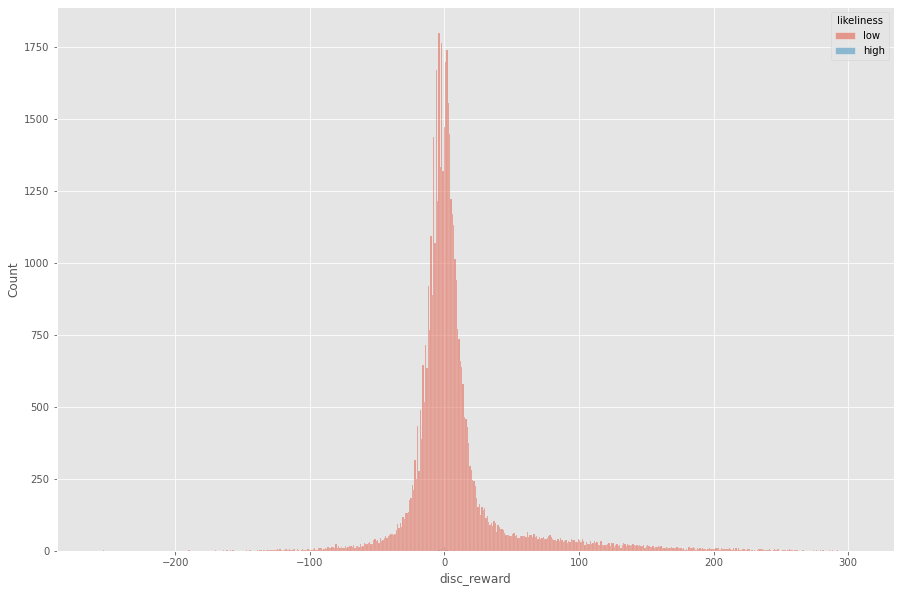

In [10]:
analysis = pd.DataFrame(disc_return_per_user)
analysis['prob'] = prob_per_user
analysis.loc[analysis['prob'] > 1, 'likeliness'] = 'high'
analysis.loc[analysis['prob'] < 1, 'likeliness'] = 'low'

plt.figure(figsize = (15,10))
sns.histplot(analysis, x = 'disc_reward', hue = 'likeliness')
plt.show()

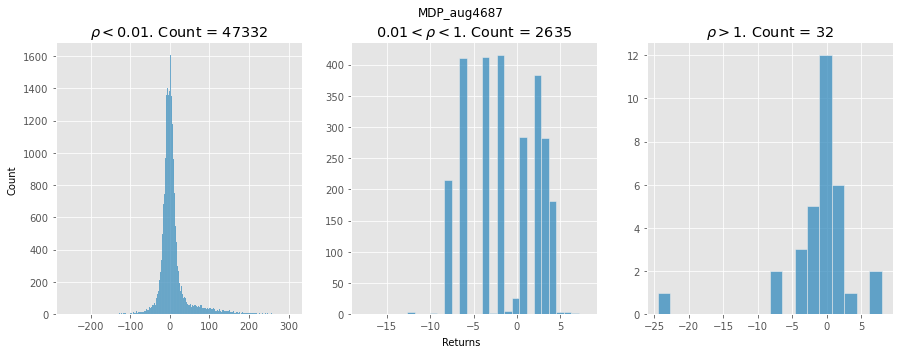

In [38]:
low = analysis.query('prob < 1 and prob > 0.01')
high = analysis.query('prob > 1 and prob < 10')
very_low = analysis.query('prob < 0.01')
very_high = analysis.query('prob > 10')

fig, axs = plt.subplots(1,3, figsize = (15,5))

sns.histplot(very_low, x = 'disc_reward', ax = axs[0])
axs[0].set_title(r'$\rho < 0.01$. Count = {}'.format(len(very_low)))
axs[0].set(xlabel=None)
axs[0].set(ylabel=None)


sns.histplot(low, x = 'disc_reward', ax = axs[1])
axs[1].set_title(r'$0.01 < \rho < 1$. Count = {}'.format(len(low)))
axs[1].set(xlabel=None)
axs[1].set(ylabel=None)

sns.histplot(high, x = 'disc_reward', ax = axs[2])
axs[2].set_title(r'$\rho > 1$. Count = {}'.format(len(high)))
axs[2].set(xlabel=None)
axs[2].set(ylabel=None)

fig.text(0.5, 0.04, 'Returns', ha='center')
fig.text(0.08, 0.5, 'Count', va='center', rotation='vertical')
fig.suptitle('MDP_aug4687')
plt.savefig('Saved_Figs/IS_trajectory_likeliness.png')
plt.show()